# Imagem

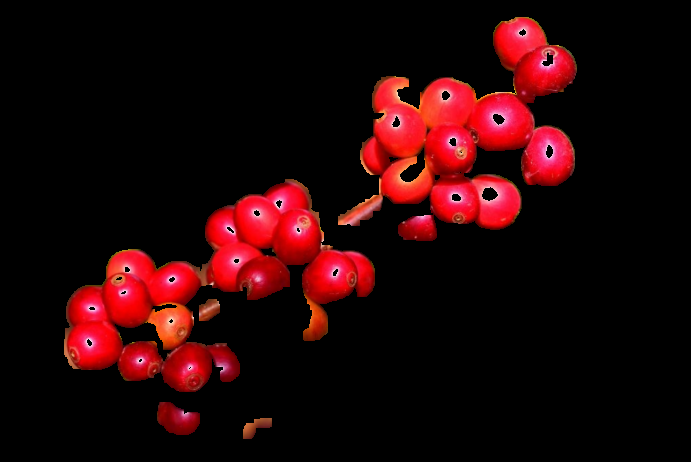

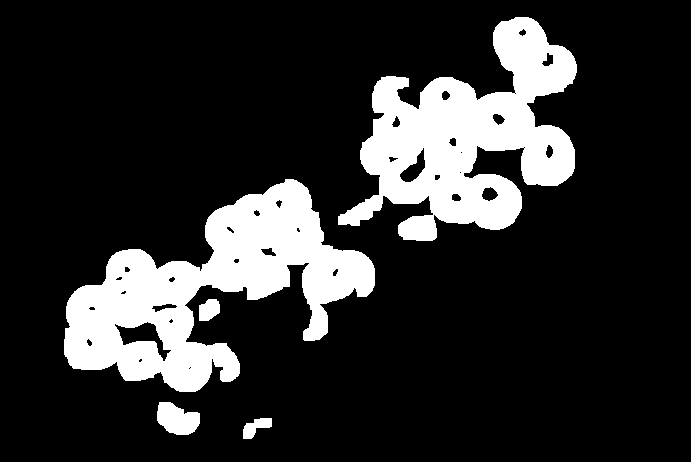

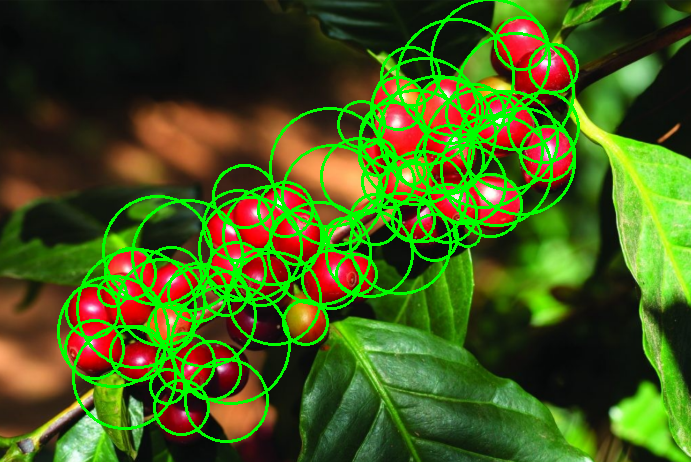

In [ ]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow

uploaded = files.upload()
img = cv2.imread('Cafe.png')

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

cv2_imshow(img)
cv2_imshow(hsv)

# Definindo Upper e Lower
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([179, 255, 255])

# Criando mascaras para cada faixa de vermelho
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

# Combinar duas mascaras
mask = cv2.add(mask1, mask2)

# Aplicar operações para diminuir o ruido
mask = cv2.erode(mask, None, iterations = 3)
mask = cv2.dilate(mask, None, iterations = 4)

# Detectar circulos na mascára
circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=0.8, minDist=20, param1=50, param2=20, minRadius=10, maxRadius=60)

# Se encontrar circulos, desenhar no quadro origianl
if circles is not None:
  circles = np.round(circles[0, :]).astype("int")
  for (x, y, r) in circles:
    cv2.circle(img, (x, y), r, (0, 255, 0), 4) # Borda do circulo
    cv2.circle(img, (x, y), 5, (0, 0, 255), -1) # Centro do círculo

  cv2_imshow(img)
  cv2_imshow(mask)
  cv2_imshow(img)








# Vídeo

In [ ]:
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload do vídeo
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

camera = cv2.VideoCapture(video_path)

# Pegar largura, altura e FPS
frame_width = int(camera.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(camera.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = camera.get(cv2.CAP_PROP_FPS)

# Criar VideoWriter para salvar vídeo processado
output_path = "cafes_red_tracking.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Faixas de vermelho no HSV (abrangendo vários tons de café maduro)
lower_red1 = np.array([0, 120, 70])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 70])
upper_red2 = np.array([179, 255, 255])

# Cor para desenhar (BGR)
color_red = (0, 0, 255)

while True:
    grabbed, frame = camera.read()
    if not grabbed or frame is None:
        break

    frame = imutils.resize(frame, width=600)

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Máscaras para diferentes faixas de vermelho
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    # Filtrar ruídos
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Encontrar contornos
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)[-2]

    for c in cnts:
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)

        if M["m00"] > 0 and radius > 5:  # aumenta o limiar do raio p/ evitar detectar pontos falsos
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            cv2.circle(frame, (int(x), int(y)), int(radius), color_red, 2)
            cv2.putText(frame, "Cafe", (int(x - radius), int(y - radius)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_red, 2)

    # Mostrar no Colab
    cv2_imshow(frame)

    # Salvar no vídeo final
    frame_resized = cv2.resize(frame, (frame_width, frame_height))
    out.write(frame_resized)

camera.release()
out.release()
print("Vídeo salvo como:", output_path)
